In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections.abc import Iterable
from typing import Any

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid, train_test_split
from sklearn.pipeline import FunctionTransformer, Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from tqdm import tqdm

from src import business, modeling, transforms, vis
from src.const import DATA_PATH, TARGET

# Для более качественных графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
age_mapping = {
    "45-54": 3,     
    "35-44": 2,    
    "55-64": 4,     
    "65-74": 5,  
    "25-34": 1,    
    ">74": 6,       
    "<25": 0, 
}

gender_mapping = {
    "м": 1,     
    "ж": 2,     
}


In [11]:
!pip install openai

   ---------------------------------------- 0.0/472.3 kB ? eta -:--:--
   ----- ---------------------------------- 61.4/472.3 kB 1.6 MB/s eta 0:00:01
   ------- -------------------------------- 92.2/472.3 kB 1.3 MB/s eta 0:00:01
   -------------- ------------------------- 174.1/472.3 kB 2.1 MB/s eta 0:00:01
   -------------------------- ------------- 307.2/472.3 kB 2.1 MB/s eta 0:00:01
   ------------------------------- -------- 368.6/472.3 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 472.3/472.3 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/204.7 kB ? eta -:--:--
   --------------------------------------- 204.7/204.7 kB 13.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/431.7 kB ? eta -:--:--
   ------------------------------------ -- 399.4/431.7 kB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 431.7/431.7 kB 6.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import openai
from getpass import getpass


def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")

_getpass("OPENAI_API_KEY") 

In [12]:
import json
def send_message(user_input):
    prompt = """
    You're a loan officer's assistant. I'll give you a customer's message, evaluate how reliable a customer he is. Evaluate its reliability on a scale from 1 to 10, and also describe the reasons.
    Much score is better (A more reliable borrower)
    In response, give json in this form {"reason": #text reasons#, "score": #Number of score#}
    
    User message:\n
    """
    messages = []
    messages.append({"role": "user", "content": prompt+user_input})

    completion = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages
    )

    assistant_reply = completion.choices[0].message.content
    messages.append({"role": "assistant", "content": assistant_reply})
    try:
        return int(json.loads(assistant_reply)["score"])
    except Exception as e:
        print(e)
        return -1

In [13]:
print("Assistant:", send_message("Hi! Can i take money, stupid ass"))

Assistant: 2


In [ ]:
loan_data = pd.read_csv(DATA_PATH)
loan_data = pd.concat([
    loan_data[loan_data["дефолт"] == 1].sample(100),
    loan_data[loan_data["дефолт"] == 0].sample(100),
])
llm_scores = [send_message(text) for text in tqdm(loan_data["речь"])]
loan_data["llm_score"] = llm_scores

In [23]:
df_train = loan_data
df_train_original = df_train.copy()

df_train["возраст"] = df_train["возраст"].map(age_mapping).fillna(7) 

df_train["пол"] = df_train["пол"].map(gender_mapping).fillna(0) 

category_counts = df_train["сбор"].value_counts()
rare_categories = category_counts[category_counts < 5].index

df_train["сбор"] = df_train["сбор"].replace(rare_categories, 'RARE')

sbor_mean_encoding = df_train.groupby('сбор')['дефолт'].mean()
df_train['сбор_mean_encoded'] = df_train.pop('сбор').map(sbor_mean_encoding)

liv_mean_encoding = df_train.groupby('проживание')['дефолт'].mean()
df_train['проживание_mean_encoded'] = df_train.pop('проживание').map(liv_mean_encoding)

df_train.drop(columns=["тип_залога"], inplace=True)

df_train["символов_в_речи"] = df_train.pop("речь").str.len()

imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(df_train)

df_train = pd.DataFrame(imputer.transform(df_train), columns=df_train.columns)

In [25]:
X_train = df_train.drop(columns=[TARGET])
y_train = df_train[TARGET].astype(int)

In [26]:
def our_profit(loan_amount, y_pred, y_true):
    return np.where(
        (y_true == 1) & (y_pred == 0),
        -loan_amount * 0.5,
        np.where(
            (y_true == 0) & (y_pred == 0),
            loan_amount * 0.1,
            0
        )
    ).sum()

In [27]:
X_train

,лимит_нарушен,пол,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,срок,амортизация,...,один_платеж,стоимость_имущества,тип_кредита,кредитный_рейтинг,возраст,прямой_залог,llm_score,сбор_mean_encoded,проживание_mean_encoded,символов_в_речи
0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,524765.264968,365.885949,0.0,...,0.0,454488.111841,1.0,713.008335,3.0,1.0,4.0,0.472222,0.5,233.0
1,0.0,0.0,3.0,2.0,1.0,0.0,0.0,224765.264968,185.885949,0.0,...,0.0,694488.111841,2.0,713.008335,4.0,1.0,6.0,0.472222,0.5,222.0
2,0.0,0.0,3.0,0.0,1.0,0.0,0.0,324765.264968,365.885949,0.0,...,1.0,454488.111841,4.0,530.508335,4.0,1.0,5.0,0.472222,0.5,218.0
3,0.0,2.0,3.0,1.0,1.0,0.0,0.0,334765.264968,365.885949,0.0,...,0.0,434488.111841,2.0,566.508335,3.0,1.0,7.0,0.472222,0.5,285.0
4,0.0,1.0,3.0,3.0,1.0,0.0,0.0,474765.264968,365.885949,0.0,...,0.0,454488.111841,2.0,878.508335,1.0,1.0,7.0,1.000000,0.5,223.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,2.0,3.0,0.0,1.0,0.0,0.0,294765.264968,245.885949,0.0,...,0.0,394488.111841,2.0,628.508335,3.0,1.0,8.0,0.472222,0.5,235.0
196,0.0,0.0,1.0,0.0,1.0,0.0,0.0,324765.264968,365.885949,0.0,...,0.0,284488.111841,3.0,519.508335,5.0,1.0,7.0,0.472222,0.5,221.0
197,0.0,0.0,3.0,3.0,1.0,0.0,0.0,424765.264968,365.885949,0.0,...,0.0,844488.111841,2.0,896.508335,4.0,1.0,6.0,0.472222,0.5,248.0
198,0.0,1.0,2.0,0.0,1.0,0.0,1.0,324765.264968,365.885949,0.0,...,0.0,444488.111841,2.0,658.508335,2.0,1.0,7.0,0.472222,0.5,233.0


In [28]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
print("Бизнес-метрика на трейне", our_profit(df_train["сумма"], y_pred_train, y_train))
print("Точность на трейне:", clf.score(X_train, y_train))

Бизнес-метрика на трейне 3648652.6496797786
Точность на трейне: 1.0


In [31]:
pd.Series(dict(zip(X_train.columns, clf.feature_importances_))).sort_values(ascending=False).head(10)

llm_score              0.243489
стоимость_имущества    0.136343
тип_кредита            0.119427
символов_в_речи        0.102431
кредитный_рейтинг      0.091216
сумма                  0.070419
возраст                0.040429
пол                    0.031942
срок                   0.030408
амортизация            0.024152
dtype: float64

In [32]:
clf = RandomForestClassifier()
clf.fit(X_train.drop(columns=["llm_score"]), y_train)

y_pred_train = clf.predict(X_train.drop(columns=["llm_score"]))
print("Бизнес-метрика на трейне", our_profit(df_train["сумма"], y_pred_train, y_train))
print("Точность на трейне:", clf.score(X_train.drop(columns=["llm_score"]), y_train))

Бизнес-метрика на трейне 3648652.6496797786
Точность на трейне: 1.0


In [33]:
pd.Series(dict(zip(X_train.columns, clf.feature_importances_))).sort_values(ascending=False).head(10)

стоимость_имущества        0.167581
тип_кредита                0.154838
проживание_mean_encoded    0.143347
кредитный_рейтинг          0.118973
сумма                      0.100969
возраст                    0.064303
пол                        0.038808
цель                       0.038403
амортизация                0.032623
llm_score                  0.031936
dtype: float64

In [167]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred_train = clf.predict_proba(X_train)
y_pred_test = clf.predict_proba(X_test)

pts = []

for t in np.linspace(0, 1, 100):
    y_pred_train_t = (y_pred_train[:, 1] > t).astype(int)
    y_pred_test_t = (y_pred_test[:, 1] > t).astype(int)

    profit_train_t = our_profit(df_train["сумма"], y_pred_train_t, y_train)
    profit_test_t = our_profit(df_test["сумма"], y_pred_test_t, y_test)

    pts.append((t, profit_train_t, profit_test_t))
stats_t = pd.DataFrame(pts, columns=["t", "profit@train", "profit@test"])

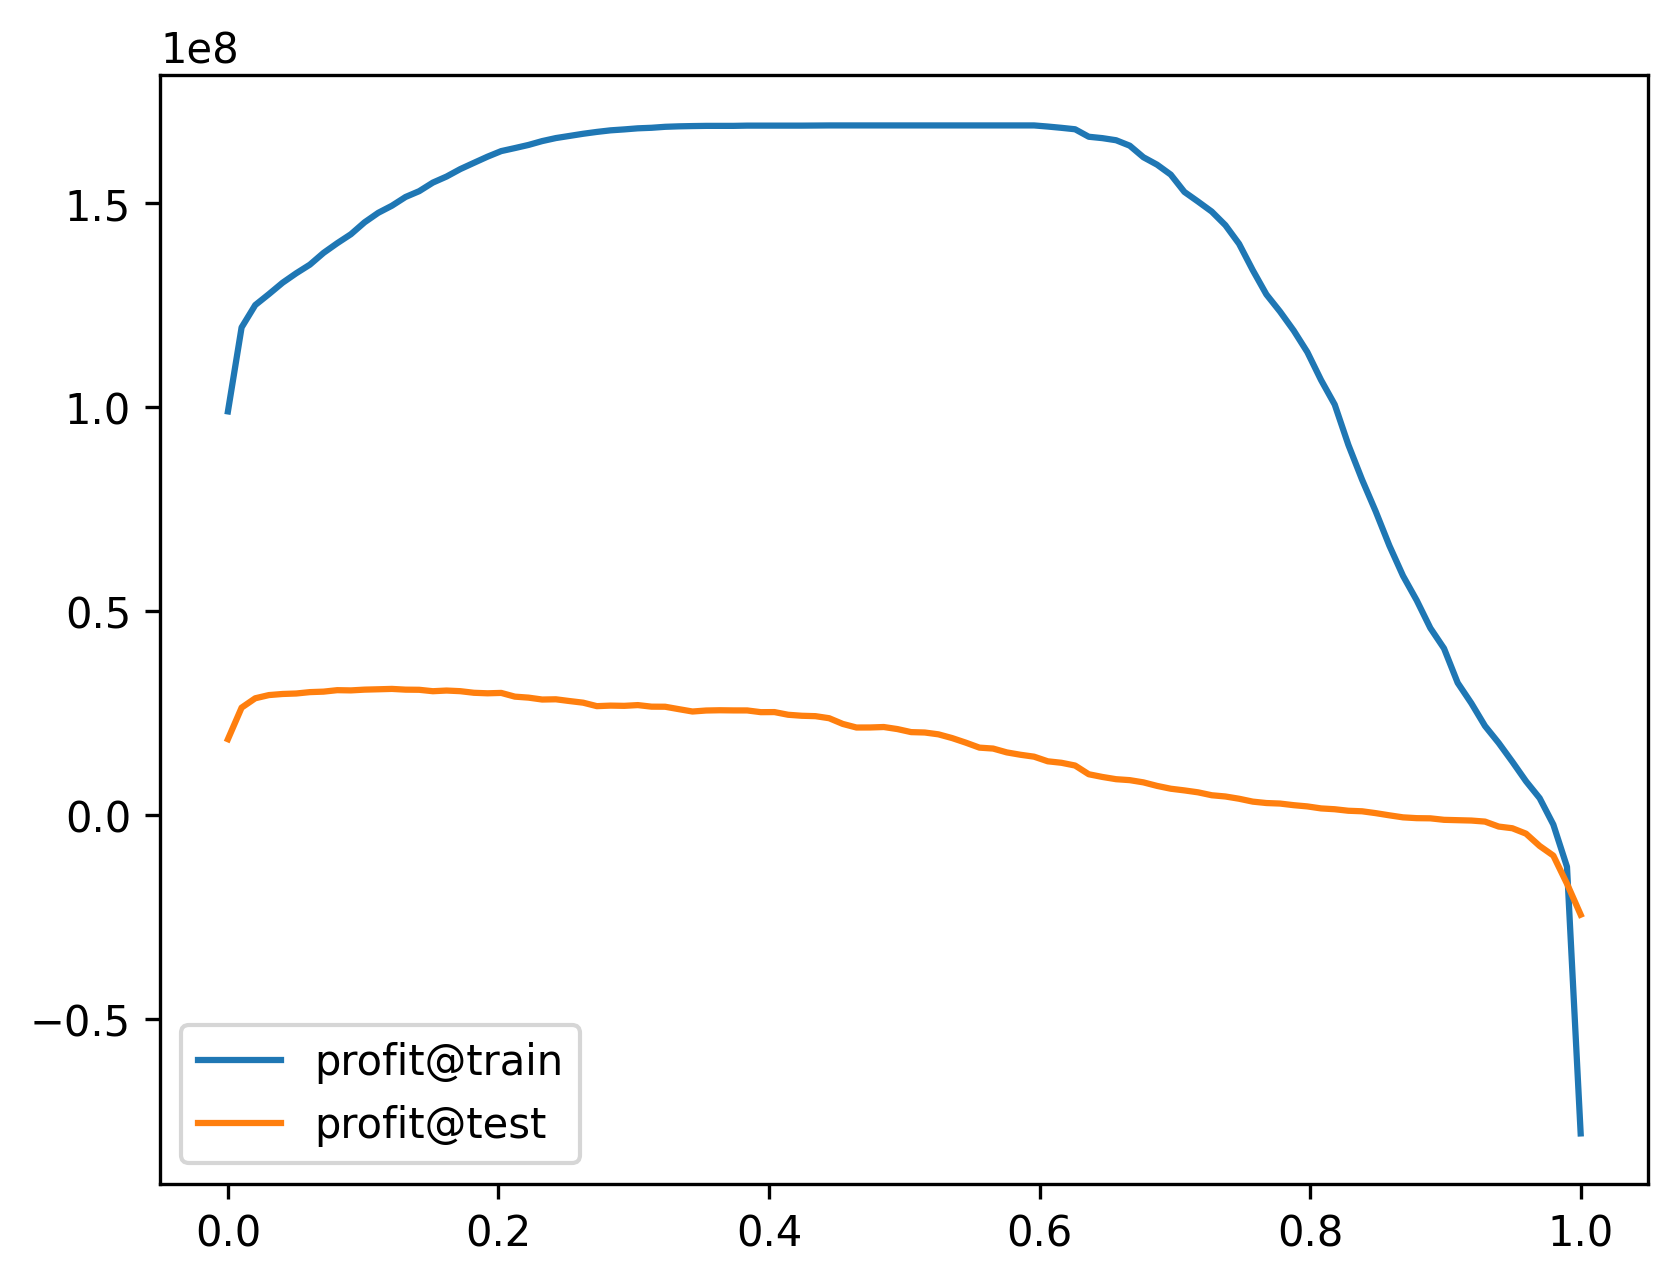

In [175]:
plt.plot(stats_t["t"], stats_t["profit@train"], label="profit@train")
plt.plot(stats_t["t"], stats_t["profit@test"], label="profit@test")
plt.legend()

In [177]:
stats_t.sort_values(by=["profit@test"], ascending=False)

,t,profit@train,profit@test
12,0.121212,1.494365e+08,3.095360e+07
11,0.111111,1.476980e+08,3.086260e+07
10,0.101010,1.453709e+08,3.077565e+07
13,0.131313,1.515848e+08,3.077117e+07
14,0.141414,1.530124e+08,3.073669e+07
...,...,...,...
95,0.959596,8.317963e+06,-4.540547e+06
96,0.969697,4.162188e+06,-7.561287e+06
97,0.979798,-2.310735e+06,-9.922026e+06
98,0.989899,-1.266799e+07,-1.682042e+07


In [ ]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred_train = clf.predict_(X_train)
y_pred_test = clf.predict(X_test)

In [156]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Бизнес-метрика на трейне", our_profit(df_train["сумма"], y_pred_train, y_train))
print("Бизнес-метрика на тесте", our_profit(df_test["сумма"], y_pred_test, y_test))
print("Точность на трейне:", clf.score(X_train, y_train))
print("Точность на тесте:", clf.score(X_test, y_test))

Бизнес-метрика на трейне 94674361.3162497
Бизнес-метрика на тесте 20904857.286229625
Точность на трейне: 0.8834375
Точность на тесте: 0.87625


In [ ]:
# если дефолт не было, зарабатываем 10%,
# если был: теряем 50% от суммы
# 

In [123]:
X_train

,лимит_нарушен,пол,тип,цель,кредитоспособность,другие_кредиты,бизнес,сумма,срок,амортизация,только_процент,один_платеж,стоимость_имущества,тип_кредита,кредитный_рейтинг,возраст,прямой_залог,сбор_mean_encoded,проживание_mean_encoded,символов_в_речи
0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,304765.264968,365.885949,0.0,0.0,0.0,3.744881e+05,2.0,799.508335,3.0,1.0,0.000000,0.231492,232.0
1,1.0,0.0,1.0,3.0,1.0,0.0,0.0,314765.264968,365.885949,0.0,0.0,0.0,9.444881e+05,3.0,672.508335,1.0,1.0,0.619048,0.231492,244.0
2,0.0,0.0,3.0,0.0,1.0,0.0,0.0,744765.264968,245.885949,0.0,0.0,0.0,1.294488e+06,2.0,708.508335,3.0,1.0,0.000000,0.231492,278.0
3,0.0,1.0,2.0,3.0,1.0,0.0,0.0,284765.264968,365.885949,0.0,0.0,0.0,4.544881e+05,4.0,708.508335,0.0,1.0,0.641026,0.231492,266.0
4,0.0,0.0,2.0,3.0,1.0,0.0,1.0,204765.264968,365.885949,1.0,0.0,0.0,4.544881e+05,4.0,713.508335,5.0,1.0,0.547619,0.231492,214.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0.0,0.0,3.0,1.0,1.0,0.0,0.0,314765.264968,365.885949,0.0,0.0,0.0,9.444881e+05,3.0,708.508335,5.0,1.0,0.000000,0.231492,252.0
6396,0.0,0.0,3.0,0.0,1.0,0.0,0.0,424765.264968,329.885949,0.0,0.0,0.0,4.544881e+05,1.0,824.508335,5.0,1.0,0.641026,0.231492,293.0
6397,0.0,0.0,2.0,1.0,1.0,0.0,1.0,234765.264968,365.885949,1.0,0.0,0.0,2.844881e+05,1.0,862.508335,3.0,1.0,0.000000,0.231492,230.0
6398,0.0,0.0,3.0,3.0,1.0,0.0,0.0,164765.264968,365.885949,1.0,0.0,0.0,2.244881e+05,2.0,708.508335,2.0,1.0,0.000000,0.231492,248.0
